## Libraries

In [1]:
import pandas as pd
import os
import time

# work with directories
from pathlib import Path 

# datetime
#import datetime as dt
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

# work with data
import numpy as np

# visualize data
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Proceess, models & metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate

# so it looks pretty
import warnings
warnings.filterwarnings('ignore')


SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Import data

Also dropping columns not required for tree-based models

In [2]:
# set paths
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

In [3]:
# import 
df_og = pd.read_csv(os.path.abspath(parent_path + '/data/preprocessed_df.csv'))

# to datetime
df_og['month_year'] = pd.to_datetime(df_og['month_year'])
print('time span: ', df_og.month_year.min(), ' to ', df_og.month_year.max()) 

# check dimensions
print('before dropping lstm columns')
print('shape:', df_og.shape, 'NaN (due to lstm targets):', df_og.isna().sum().sum()) # (79875, 110)


# drop lstm specific columns 
lstm_cols = ['f3_target_escl', 'f6_target_escl', 'f3_target_clsf', 'f6_target_clsf', 'f3_target_regr', 'f6_target_regr', 'month', 'year']
df_og.drop(columns=lstm_cols, inplace=True)

# check dimensions
print('after dropping lstm columns')
print('shape:', df_og.shape, 'NaN (now all gone):', df_og.isna().sum().sum())  # (79875, 110)


# optional: shorten training set by starting later than January 2000
#drop_before = dt(2000, 1, 1) # instead of starting from 1989
#prepped_data = df_og[df_og.month_year >= drop_before ]

df_og.columns


time span:  2000-01-01 00:00:00  to  2023-03-01 00:00:00
before dropping lstm columns
shape: (54915, 88) NaN (due to lstm targets): 5319
after dropping lstm columns
shape: (54915, 80) NaN (now all gone): 0


Index(['isocode', 'month_year', 'Country Name', 'deaths_all_pc', 'armedconf',
       'escalation', 'past6', 'past12', 'past60', 'past120', 'armedconf_since',
       'deaths_stock', 'share_events_1', 'share_events_2', 'share_events_3',
       'share_events_4', 'share_events_5', 'share_events_6', 'share_events_7',
       'share_events_8', 'share_events_9', 'share_events_10',
       'share_events_11', 'share_events_12', 'share_events_13',
       'share_events_14', 'share_events_15', 'share_events_16',
       'share_events_17', 'share_events_18', 'share_events_19',
       'share_events_20', 'share_events_gov', 'share_events_opp',
       'norm_total_events', 'event_share_1_stock', 'event_share_2_stock',
       'event_share_3_stock', 'event_share_4_stock', 'event_share_5_stock',
       'event_share_6_stock', 'event_share_7_stock', 'event_share_8_stock',
       'event_share_9_stock', 'event_share_10_stock', 'event_share_11_stock',
       'event_share_12_stock', 'event_share_13_stock', 'event_

## Speficy targets and text data period

We demonstrate
- how to generate a full list of months in the test data in order to loop over it when generating the expanding window
- how the two make_target functions work for the classification and regression targets

In [4]:
# classification targets
target_conf = 'armedconf'
target_regr = 'deaths_all_pc'
target_escl = 'escalation'

unit_of_analyis = 'isocode'

start_month_year = dt(2018, 1, 1)
end_month_year = dt(2023, 3, 1)


In [5]:
def generate_monthly_dates(start_month_year, end_month_year):
    current_date = start_month_year.replace(day=1)
    dates = []

    while current_date <= end_month_year:
        dates.append(current_date)
        current_date += relativedelta(months=1)
        
    return dates

dates = generate_monthly_dates(start_month_year, end_month_year)
for date in dates:
      print(date.strftime('%Y-%m-%d'))

2018-01-01
2018-02-01
2018-03-01
2018-04-01
2018-05-01
2018-06-01
2018-07-01
2018-08-01
2018-09-01
2018-10-01
2018-11-01
2018-12-01
2019-01-01
2019-02-01
2019-03-01
2019-04-01
2019-05-01
2019-06-01
2019-07-01
2019-08-01
2019-09-01
2019-10-01
2019-11-01
2019-12-01
2020-01-01
2020-02-01
2020-03-01
2020-04-01
2020-05-01
2020-06-01
2020-07-01
2020-08-01
2020-09-01
2020-10-01
2020-11-01
2020-12-01
2021-01-01
2021-02-01
2021-03-01
2021-04-01
2021-05-01
2021-06-01
2021-07-01
2021-08-01
2021-09-01
2021-10-01
2021-11-01
2021-12-01
2022-01-01
2022-02-01
2022-03-01
2022-04-01
2022-05-01
2022-06-01
2022-07-01
2022-08-01
2022-09-01
2022-10-01
2022-11-01
2022-12-01
2023-01-01
2023-02-01
2023-03-01


In [6]:
def make_target_clsf(df: pd.DataFrame, shifter: int, target: str): # t is the number of periods for the shift

    # loop through each period and generate the shift variables (name doesn't matter, just interim columns to take max)
    for i in range(1, shifter+1):
        col_name = f'{target}{i}'
        df[col_name] = df.groupby(unit_of_analyis)[str(target)].shift(-i)

    # take the maximum for t periods forward and create the new variable & drop the shift variables
    df[f'{target}_f{shifter}'] = df[[f'{target}{i}' for i in range(1, shifter+1)]].max(axis=1, skipna=False)
    df = df.drop(columns=[f'{target}{i}' for i in range(1, shifter+1)])
    
    return(df)


def make_target_regr(df: pd.DataFrame, shifter: int, target: str): # t is the number of periods for the shift

    # loop through each period and generate the temporary shift variables
    for i in range(1, shifter+1):
        col_name = f'{target}{i}'
        df[col_name] = df.groupby(unit_of_analyis)[str(target)].shift(-i)

    # take the mean for t periods forward and create the new variable &
    df[f'{target}_f{shifter}'] = df[[f'{target}{i}' for i in range(1, shifter+1)]].mean(axis=1, skipna=False)

    # 
    df = df.drop(columns=[f'{target}{i}' for i in range(1, shifter+1)])
    
    return(df)

In [7]:
# demonstrating the make_target functions
df_exmpl = df_og.copy()

exmpl_shifter = 3

# generate binary classification  targets
df_exmpl = make_target_clsf(df_exmpl, exmpl_shifter, target_conf)
df_exmpl = make_target_clsf(df_exmpl, exmpl_shifter, target_escl)

# generate regression target
df_exmpl[f'OLD_target_regr_f{exmpl_shifter}'] = df_exmpl.groupby(unit_of_analyis)[target_regr].shift(-exmpl_shifter)
df_exmpl = make_target_regr(df_exmpl, exmpl_shifter, target_regr)

# check it worked
df_exmpl.loc[df_exmpl['isocode'] == 'BFA', ['isocode', 'Country Name', 'month_year',  'armedconf',  f'{target_escl}_f{exmpl_shifter}', f'{target_conf}_f{exmpl_shifter}','deaths_all_pc', f'{target_regr}_f{exmpl_shifter}', f'OLD_target_regr_f{exmpl_shifter}']][-8:]

,isocode,Country Name,month_year,armedconf,escalation_f3,armedconf_f3,deaths_all_pc,deaths_all_pc_f3,OLD_target_regr_f3
43378,BFA,Burkina Faso,2022-08-01,True,0.0,1.0,1.475068,0.754125,0.918524
43379,BFA,Burkina Faso,2022-09-01,True,0.0,1.0,0.868751,0.758649,0.882326
43380,BFA,Burkina Faso,2022-10-01,True,0.0,1.0,0.475098,0.600283,0.000000
43381,BFA,Burkina Faso,2022-11-01,True,1.0,1.0,0.918524,1.010527,2.149255
43382,BFA,Burkina Faso,2022-12-01,True,1.0,1.0,0.882326,1.561038,2.533858
43383,BFA,Burkina Faso,2023-01-01,False,NaN,NaN,0.000000,NaN,NaN
43384,BFA,Burkina Faso,2023-02-01,True,NaN,NaN,2.149255,NaN,NaN
43385,BFA,Burkina Faso,2023-03-01,True,NaN,NaN,2.533858,NaN,NaN


## Prepare slice: allowing for an expanding window to train on

We demonstrate how the prepare_slice function can subset the data differently for different models and targets.

Beforehand, we speficy which columns will be accessible for the history (no-text), the text (GDELT-only) and the all (combined) models.

In [8]:
df = df_og.copy()

In [9]:
# Columns dropped while fitting, but added to identify predictions
time_var = ['month_year']
id_var = ['isocode']


# Lists of variables to keep for each model (NB past currently only based on total number of deaths per )

historical_vars = ['deaths_all_pc', 'armedconf', 'escalation', 'armedconf_since', 'deaths_stock', 'past6', 'past12', 'past60', 'past120',
                   'share_state_deaths', 'share_nonstate_deaths', 'share_onesided_deaths', 'share_civilian_deaths',
                   'refugees_in', 'refugees_out', 'neighbor_conflict']

event_shares = ['share_events_{}'.format(i) for i in range(1, 21)] 
event_share_stock = ['event_share_{}_stock'.format(i) for i in range(1, 21)]
event_share_actor = ['share_events_gov', 'share_events_opp']
event_total = ['norm_total_events']
gdelt_admin1 = ['num_regions', 'Adm1_Max', 'Adm1_Mean', 'Adm1_Median']
clusters = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3']

text_gdelt_vars = event_shares + event_share_stock + event_share_actor + event_total + gdelt_admin1 + clusters

other_vars = ['month_sin', 'month_cos', 'isocode_0','isocode_1','isocode_2','isocode_3','isocode_4','isocode_5','isocode_6','isocode_7'] 

cols_not_used = set(df.columns) - set(id_var + historical_vars + text_gdelt_vars + time_var + other_vars)
cols_not_used


{'Country Name'}

In [10]:
# Decide within prepare slice which columns to include for each model and adjust these lengths accordingly - they allow us to keep track of feature importance, an addition we made to Hannes's original code
combomodel_var_len = len(other_vars + historical_vars + text_gdelt_vars) 
historymodel_var_len = len(other_vars + historical_vars) 
textmodel_varl_len = len(other_vars + text_gdelt_vars)

print(combomodel_var_len, historymodel_var_len, textmodel_varl_len)

77 26 61


In [11]:
def prepare_slice(df, date, target, forward, binary = True):
    df = df.copy()

    # Establish past: keep only what is before the current year 
    data = df[df.month_year < date]
    print('pre drop data: ', len(data))

    # Establish future: keep only currrent time period, which is to be predicted 
    future = df[df.month_year == date]	
    print('countries predicting for: ', len(future))


    # generate the shifted target - choosing the relevant make_target function based on whether we are predicting binary or continuous

    if binary:
        make_target_clsf(df=data, shifter=forward, target=target)
        
        # When this is used in the loop later, we will predict forward 1 and 2 business days
        deps=[f'{target}_f{forward}']
        data = data.dropna()
        y_all = data[deps].astype(int) # some models prefer 1 and 0 to True and False

    else:
        #data_target = data.groupby(unit_of_analyis)[target].shift(-forward)
        #deps=['target_regr_f{}'.format(forward)] 

        make_target_regr(df=data, shifter=forward, target=target)
        deps=[f'{target}_f{forward}']
        data = data.dropna()
        y_all = data[deps]

    y_all = y_all.values.ravel() # all models have the same target

    # choose which data to keep for which model
    # X-vars
    combomodel = historical_vars + text_gdelt_vars + other_vars
    historymodel = historical_vars + other_vars
    textmodel = text_gdelt_vars + other_vars

    # full columns with X-vars, y-var and id-vars
    combomodel_all = combomodel + id_var + time_var + deps
    historymodel_all = historymodel + id_var + time_var + deps
    textmodel_all = textmodel + id_var + time_var + deps

    # Model 1: Full or augmented/ combined model
    df_all = data[combomodel_all].dropna()
    print('training rows (post drop): ', len(df_all)) # the others have the same length

    # Model 2: History model 
    df_hs = data[historymodel_all].dropna()

    # Model 3: Pure text-based (novelty) model
    df_tx = data[textmodel_all].dropna()
    
    # Training data: X-vars - no Ticker or Date, NaNs already dropped
    X_all = df_all[combomodel]
    X_hs = df_hs[historymodel]
    X_tx = df_tx[textmodel]

    # Remove dependent variable from column lists - still includes Date and Ticker
    combomodel_all.remove(deps[0])
    historymodel_all.remove(deps[0])
    textmodel_all.remove(deps[0])

    # Use these columns for the future (out-of-sample) data for the models
    df_fut_all = future[combomodel_all].dropna()
    df_fut_hs = future[historymodel_all].dropna()
    df_fut_tx = future[textmodel_all].dropna()

    # Data (X-vars) at time T for producing fitted values - no Date or Ticker
    X_fut_all = df_fut_all[combomodel]
    X_fut_hs = df_fut_hs[historymodel]
    X_fut_tx = df_fut_tx[textmodel]

    return X_all, X_hs, X_tx, y_all, X_fut_all, X_fut_hs, X_fut_tx, df_all, df_hs, df_tx, df_fut_all, df_fut_hs, df_fut_tx


In [12]:
# Exemplification of prepare slice:
exmpl_data = df.copy()

# SET PARAMETERS for prepare_slice function
exmpl_start_date = dt(2018, 1, 1) 
exmpl_forward = 7
exmpl_target = target_escl
exmpl_binary_status = True

#apply prepare slice
X_all, X_hs, X_tx, y, X_fut_all, X_fut_hs, X_fut_tx, df_all, df_hs, df_tx, df_fut_all, df_fut_hs, df_fut_tx  = prepare_slice(exmpl_data, exmpl_start_date, exmpl_target, exmpl_forward, exmpl_binary_status)

# Explaning output
print(y.shape)

print('___COMBO___')
print(df_all.shape)   # all X-vars, other and target
print(df_fut_all.shape) # all X-vars and other, but NO dep - only 1 day

print(X_all.shape)    # no Ticker/date/target and final row removed for all 
print(X_fut_all.shape)  # no Ticker/date/target  - only 1 day

print('___HIST___')
print(df_hs.shape)
print(df_fut_hs.shape)

print(X_hs.shape)   
print(X_fut_hs.shape)

print('___TEXT___')
print(df_tx.shape)
print(df_fut_tx.shape)

print(X_tx.shape)   
print(X_fut_tx.shape)

print('___Y___')
print(y.shape)
y

pre drop data:  42504
countries predicing for:  197
training rows (post drop):  41125
(41125,)
___COMBO___
(41125, 80)
(197, 79)
(41125, 77)
(197, 77)
___HIST___
(41125, 29)
(197, 28)
(41125, 26)
(197, 26)
___TEXT___
(41125, 64)
(197, 63)
(41125, 61)
(197, 61)
___Y___
(41125,)


array([1, 1, 1, ..., 0, 0, 0])

## Generate dictionaries of parameters from gridsearches

We ran gridsearches in separate notebooks for each target and forecast-horizons. Due to time-contraints we only optimised for the data containing the GDELT-only variables (i.e. the ones used for the tex-based model).

In [13]:
n_jobs = 3 

# XGBClassifier ESCALATION
opt_params_xgb_escl_f1 = {'eta': 0.3, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': n_jobs,  'missing': np.nan} #best score f1: 0.06622276029055689
opt_params_xgb_escl_f3 = {'eta': 0.01, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': n_jobs, 'missing': np.nan} #best score f3: 0.48890625
opt_params_xgb_escl_f6 = {'eta': 0.3, 'max_depth': 15, 'n_estimators': 1000, 'n_jobs': n_jobs, 'missing': np.nan} # best scoref6: 0.6299903438257723

# XGBClassifier INCIDENCE (armed conflict)
opt_params_xgb_conf_f1 = {'eta': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'n_jobs': n_jobs, 'missing': np.nan} # best score f1: 0.6011448508967998
opt_params_xgb_conf_f3 = {'eta': 0.01, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': n_jobs, 'missing': np.nan} # best score f3: 0.5885882541249283
opt_params_xgb_conf_f6 = {'eta': 0.3, 'max_depth': 5, 'n_estimators': 1000, 'n_jobs': n_jobs, 'missing': np.nan} # best score f6: 0.6237068763132256

#XGB Regressor:
opt_params_xgb_regr_f1 = {'eta': 0.3, 'max_depth': 5, 'n_estimators': 1000, 'n_jobs': n_jobs}
opt_params_xgb_regr_f3 = {'eta': 0.3, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': n_jobs}
opt_params_xgb_regr_f6 = {'eta': 0.01, 'max_depth': 15, 'n_estimators': 100, 'n_jobs': n_jobs}


# RFClassifier ESCALATION
opt_params_rf_escl_f1 = {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'class_weight' : 'balanced', 'n_jobs' : n_jobs} # best score f1: 0.004511986180139614
opt_params_rf_escl_f3 = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000, 'class_weight' : 'balanced','n_jobs' : n_jobs } # best score f3: 0.406875
opt_params_rf_escl_f6 = {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'class_weight' : 'balanced', 'n_jobs' : n_jobs} # best score f6: 0.5906425656836514

# RFClassifier INCIDENCE (armed conflict)
opt_params_rf_conf_f1 = {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs' : n_jobs} # best score f1: 0.8911696559995639
opt_params_rf_conf_f3 = {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs' : n_jobs} # best score f3: 0.8741173253658081
opt_params_rf_conf_f6 = {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs' : n_jobs} # best score f6: 0.8528035531922387

# RF Regressor:
opt_params_rf_regr_f1 = {'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs' : n_jobs}
opt_params_rf_regr_f3 = {'max_depth': 15, 'min_samples_leaf': 100, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs' : n_jobs}
opt_params_rf_regr_f6 = {'max_depth': 15, 'min_samples_leaf': 100, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs' : n_jobs}

In [14]:
def set_params(target: str, fwd: int, algo: str):
    params_dict = {
        ('rf', target_escl, 1): RandomForestClassifier(**opt_params_rf_escl_f1),
        ('rf', target_escl, 3): RandomForestClassifier(**opt_params_rf_escl_f3),
        ('rf', target_escl, 6): RandomForestClassifier(**opt_params_rf_escl_f6),
        ('rf', target_conf, 1): RandomForestClassifier(**opt_params_rf_conf_f1),
        ('rf', target_conf, 3): RandomForestClassifier(**opt_params_rf_conf_f3),
        ('rf', target_conf, 6): RandomForestClassifier(**opt_params_rf_conf_f6),
        ('rf', target_regr, 1): RandomForestRegressor(**opt_params_rf_regr_f1),
        ('rf', target_regr, 3): RandomForestRegressor(**opt_params_rf_regr_f3),
        ('rf', target_regr, 6): RandomForestRegressor(**opt_params_rf_regr_f6),

        ('xgb', target_escl, 1): XGBClassifier(**opt_params_xgb_escl_f1),
        ('xgb', target_escl, 3): XGBClassifier(**opt_params_xgb_escl_f3),
        ('xgb', target_escl, 6): XGBClassifier(**opt_params_xgb_escl_f6),
        ('xgb', target_conf, 1): XGBClassifier(**opt_params_xgb_conf_f1),
        ('xgb', target_conf, 3): XGBClassifier(**opt_params_xgb_conf_f3),
        ('xgb', target_conf, 6): XGBClassifier(**opt_params_xgb_conf_f6),
        ('xgb', target_regr, 1): XGBRegressor(**opt_params_xgb_regr_f1),
        ('xgb', target_regr, 3): XGBRegressor(**opt_params_xgb_regr_f3),
        ('xgb', target_regr, 6): XGBRegressor(**opt_params_xgb_regr_f6)
    }

    optimal_algo = params_dict.get((algo, target, fwd))
    
    return optimal_algo

set_params(target = target_escl, fwd = 1, algo = 'xgb')


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=3,
              num_parallel_tree=None, predictor=None, ...)

## Choose target, algorithm and forecasting horizon to run the prediction loop

The loop can only jointly work for classification targets (conflict incidence or escalation). The check_target function automatically checks if the targets specified are permissible.

In [ ]:
# This should be dt(2023,3,1) - but to quickly check if the loop runs use (2018,2,1)
#end_month_year = dt(2023,3,1)
#end_month_year = dt(2018,2,1)

end_month_year

In [16]:
# Check dates and targets are as expected
print('Train window:', df.month_year.min(), start_month_year)
print('Test window:',start_month_year, end_month_year)

print('Target options:', target_conf, target_escl, target_regr)

print('Entire data:', df.shape)

df.head(3)

Train window: 2000-01-01 00:00:00 2018-01-01 00:00:00
Test window: 2018-01-01 00:00:00 2018-02-01 00:00:00
Target options: armedconf escalation deaths_all_pc
Entire data: (54915, 80)


,isocode,month_year,Country Name,deaths_all_pc,armedconf,escalation,past6,past12,past60,past120,...,cluster_2,cluster_3,isocode_0,isocode_1,isocode_2,isocode_3,isocode_4,isocode_5,isocode_6,isocode_7
0,AFG,2000-01-01,Afghanistan,0.276314,True,0,0.276314,0.276314,0.276314,0.276314,...,0,1,0,0,0,0,0,0,0,1
1,AFG,2000-02-01,Afghanistan,0.777290,True,1,1.053604,1.053604,1.053604,1.053604,...,0,1,0,0,0,0,0,0,0,1
2,AFG,2000-03-01,Afghanistan,1.620053,True,0,2.673657,2.673657,2.673657,2.673657,...,0,1,0,0,0,0,0,0,0,1


In [17]:
def check_target(target_choice):       

    if target_conf in target_choice and target_regr not in target_choice:
        return True
    
    if target_escl in target_choice and target_regr not in target_choice:
        return True

    elif target_regr in target_choice and target_conf not in target_choice and target_escl not in target_choice:
        return False
    
    else:
        print('Target combination not allowed: cannot combine regression with classification tasks')
        return 'Check taget_choice!!'

In [21]:
# choose algoritm from:  rf (Random Forest) and xgb (XGBoost)
algo_choice = ['xgb', 'rf']

# choose target(s) from: target_conf, target_escl, target_regr - NB you cannot combine regression with classification tasks
target_choice = [target_conf, target_escl]

# True if it's a binary classification task, False if it's a regression task
binary_status = check_target(target_choice) 

# choose months ahead to forecast:  1, 3, 6 (any or all)
fwds = [1, 3, 6]

In [22]:
binary_status

True

TARGET: armedconf (i.e. binary = True)
ALGORITHM: xgb
MONTH(S) AHEAD: 3 
Month:  2018-01-01 00:00:00
pre drop data:  42504
countries predicing for:  197
training rows (post drop):  41913
Month:  2018-02-01 00:00:00
pre drop data:  42701
countries predicing for:  197
training rows (post drop):  42110
Saved predictions for forward  3  and target  armedconf to directory /Users/margheritaphilipp/Documents/GitHub/thesis/models


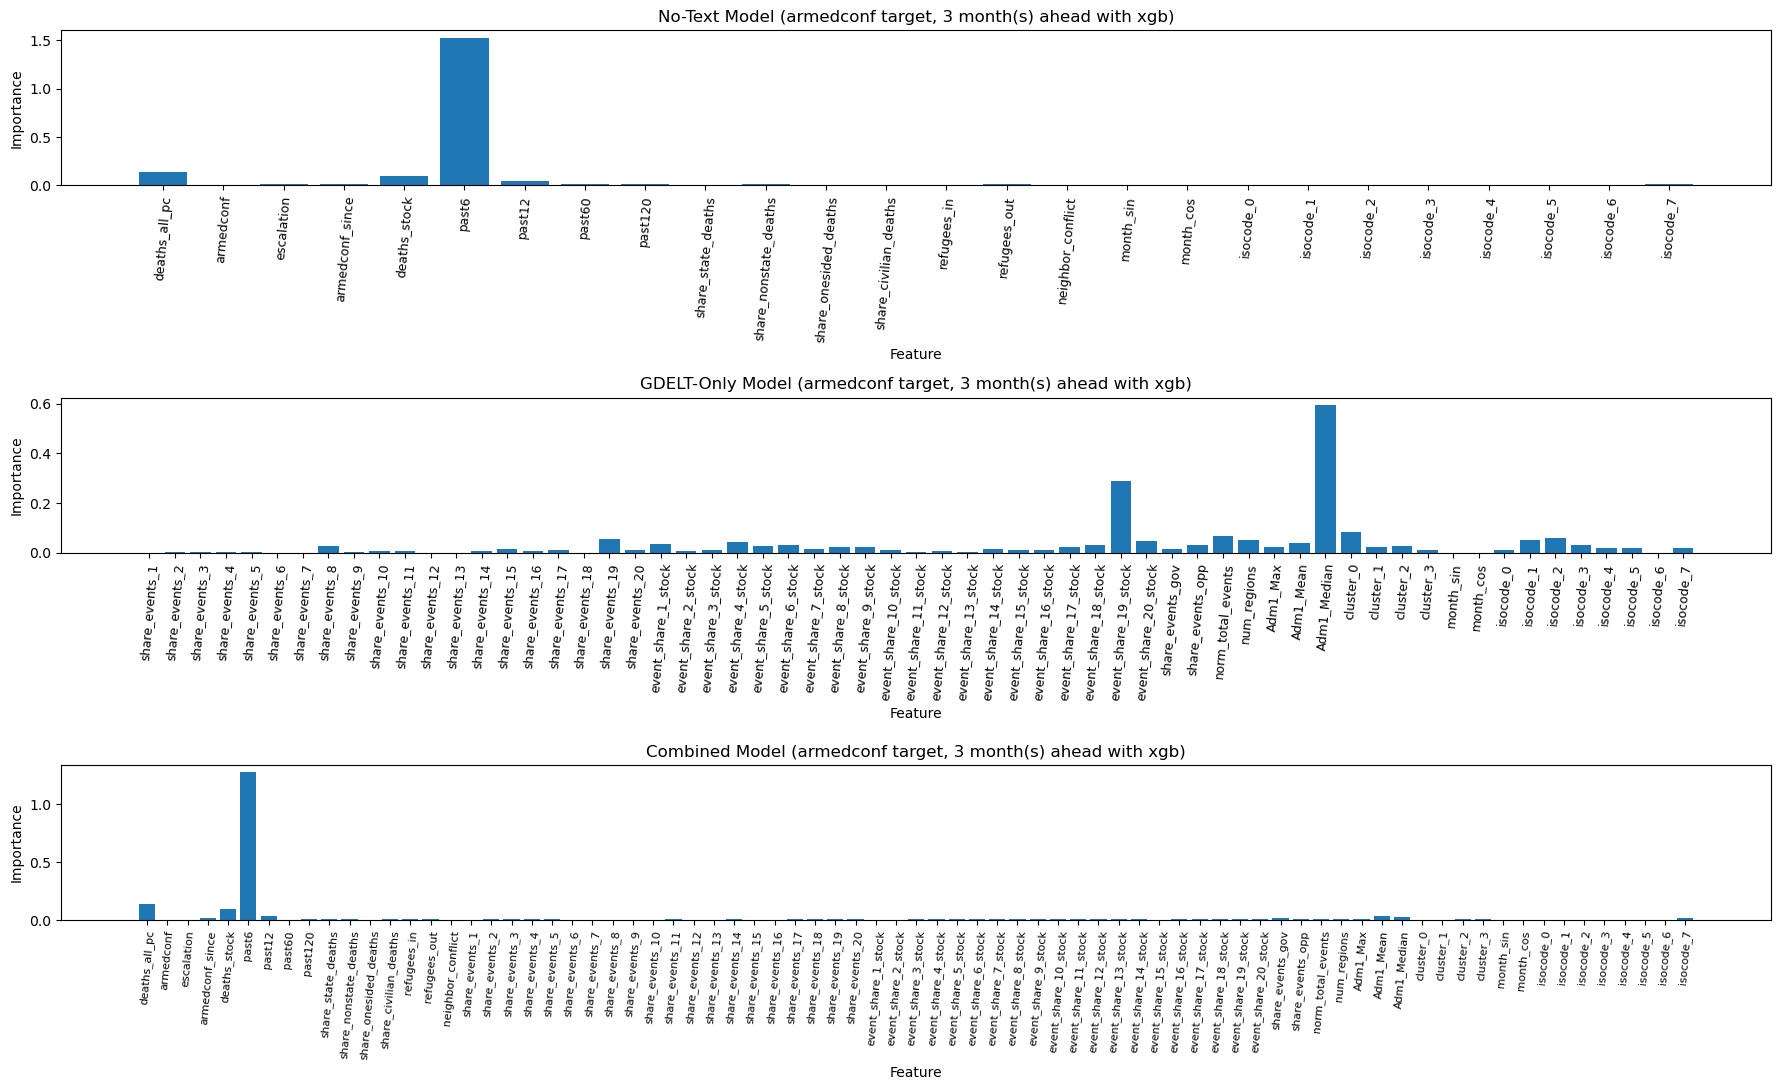

TARGET: armedconf (i.e. binary = True)
ALGORITHM: rf
MONTH(S) AHEAD: 3 
Month:  2018-01-01 00:00:00
pre drop data:  42504
countries predicing for:  197
training rows (post drop):  41913
Month:  2018-02-01 00:00:00
pre drop data:  42701
countries predicing for:  197
training rows (post drop):  42110
Saved predictions for forward  3  and target  armedconf to directory /Users/margheritaphilipp/Documents/GitHub/thesis/models


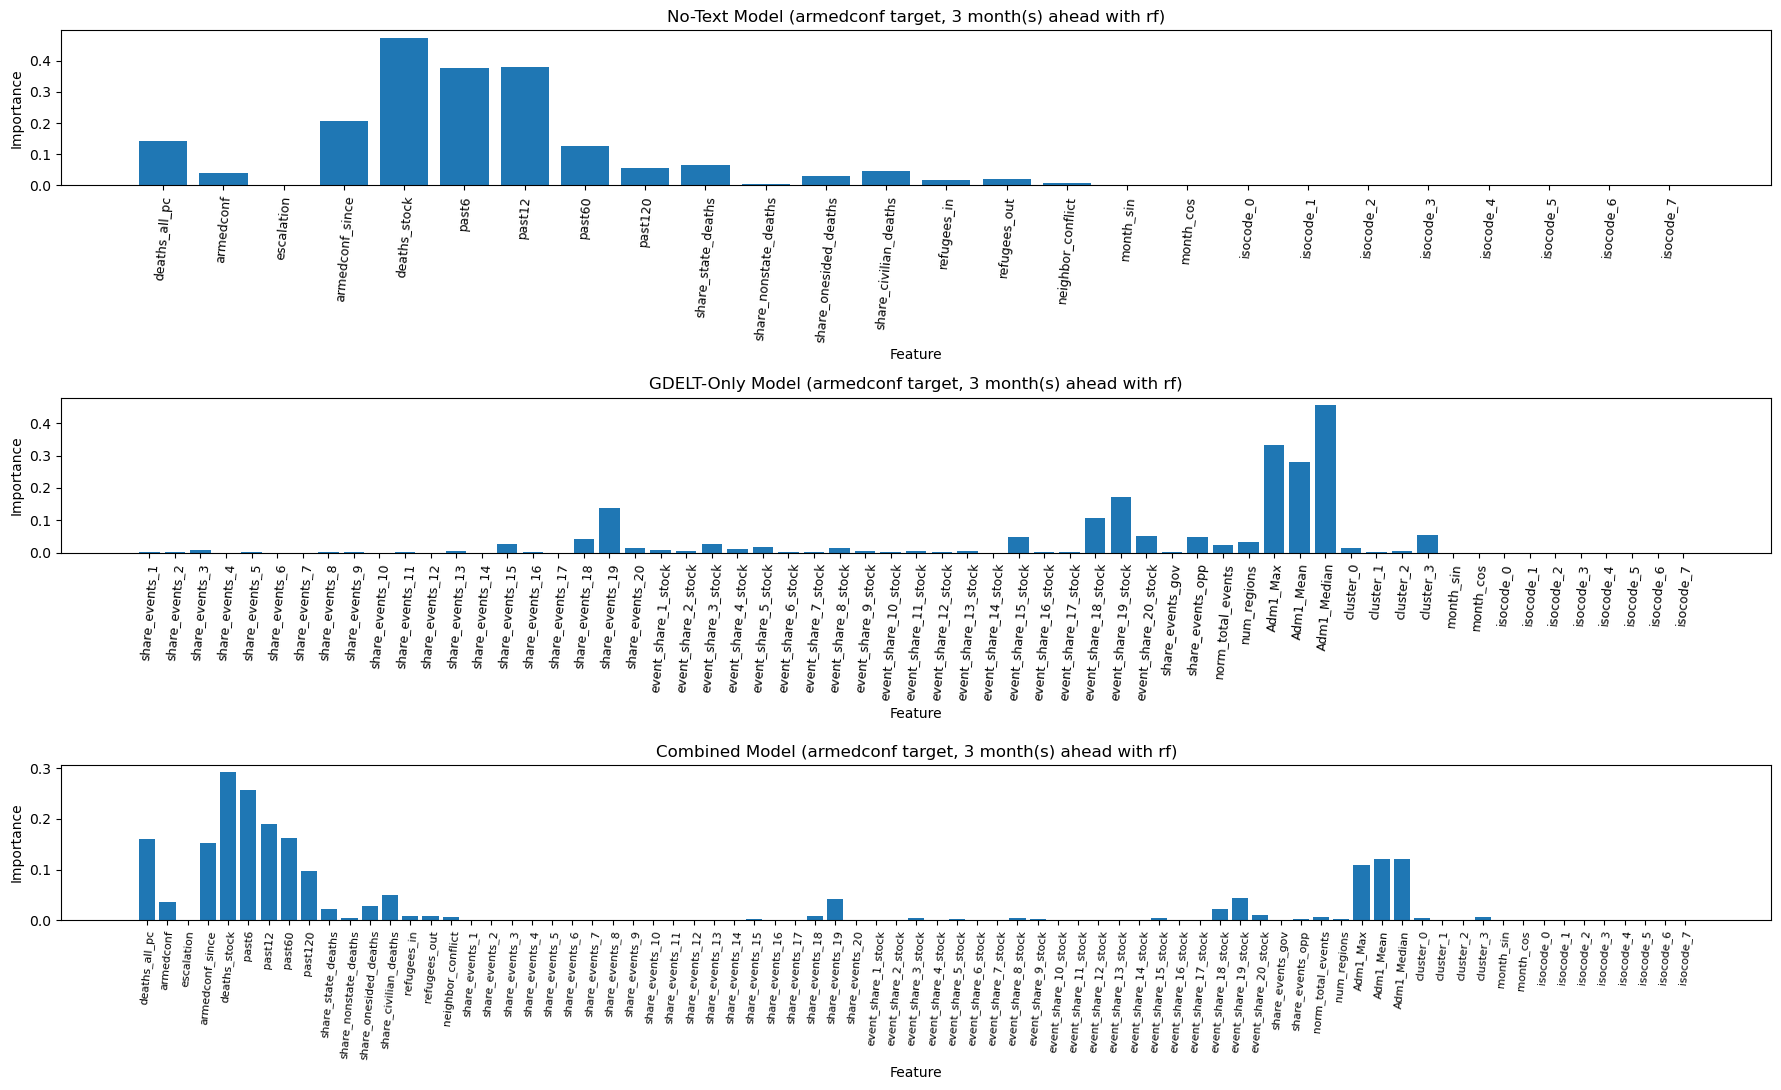

TARGET: escalation (i.e. binary = True)
ALGORITHM: xgb
MONTH(S) AHEAD: 3 
Month:  2018-01-01 00:00:00
pre drop data:  42504
countries predicing for:  197
training rows (post drop):  41913
Month:  2018-02-01 00:00:00
pre drop data:  42701
countries predicing for:  197
training rows (post drop):  42110
Saved predictions for forward  3  and target  escalation to directory /Users/margheritaphilipp/Documents/GitHub/thesis/models


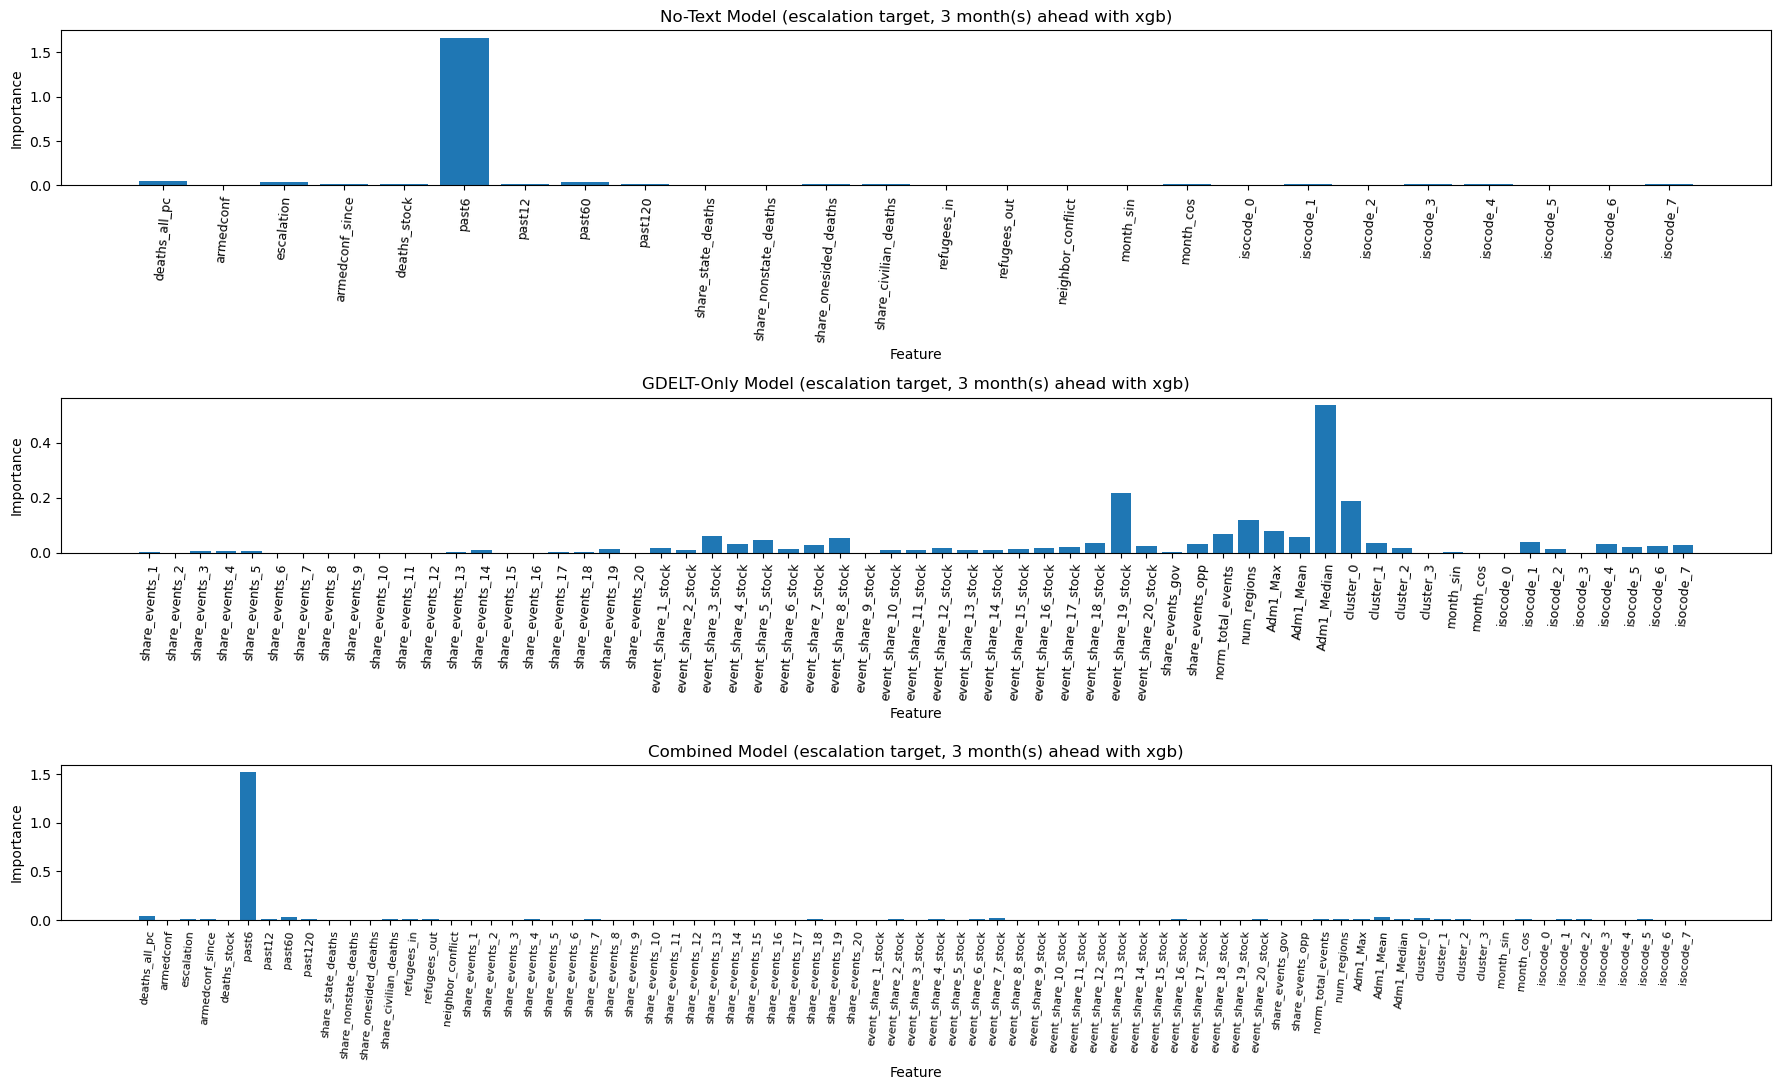

TARGET: escalation (i.e. binary = True)
ALGORITHM: rf
MONTH(S) AHEAD: 3 
Month:  2018-01-01 00:00:00
pre drop data:  42504
countries predicing for:  197
training rows (post drop):  41913
Month:  2018-02-01 00:00:00
pre drop data:  42701
countries predicing for:  197
training rows (post drop):  42110
Saved predictions for forward  3  and target  escalation to directory /Users/margheritaphilipp/Documents/GitHub/thesis/models


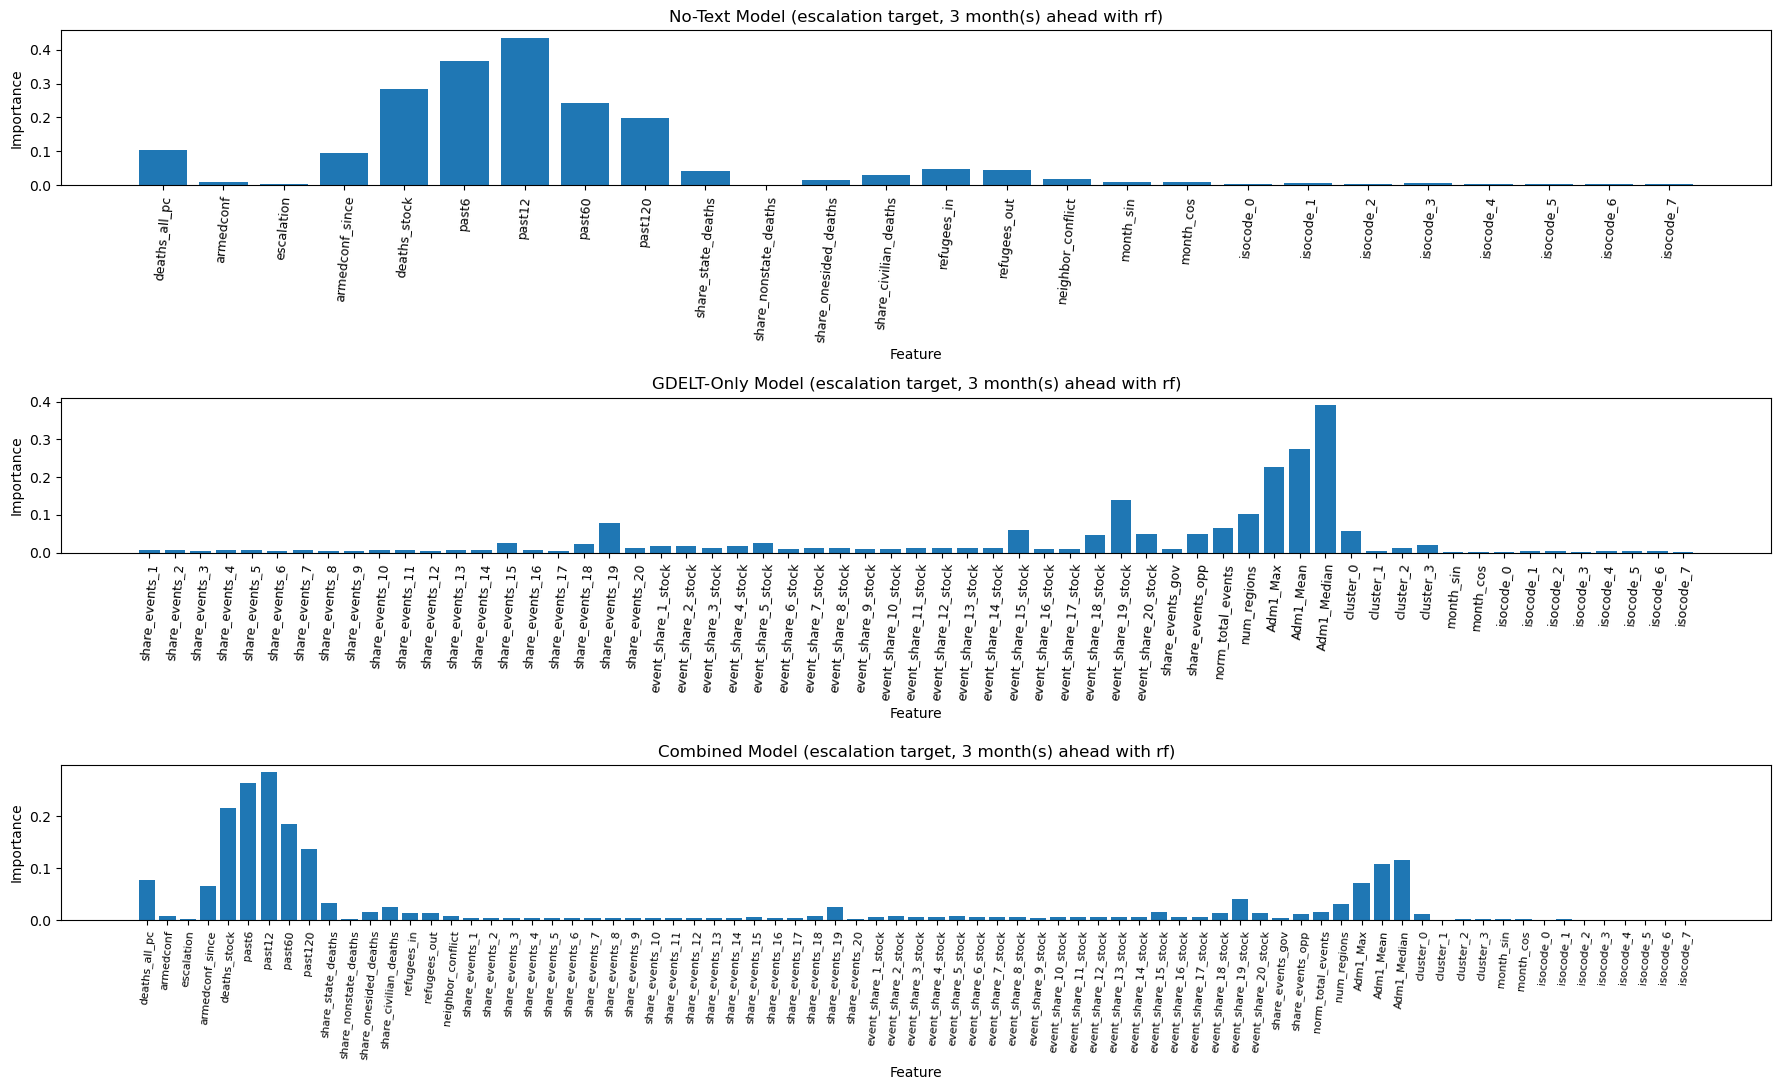

In [24]:
for dep in target_choice: 

    for algo in algo_choice: 

        for forward in fwds:

                fittedframe = pd.DataFrame(columns=id_var + time_var)

                print(f'TARGET: {dep} (i.e. binary = {binary_status})')
                print(f'ALGORITHM: {algo}')
                print(f'MONTH(S) AHEAD: {forward} ')
            
                algo_all = set_params(dep, forward, algo)
                algo_hs = set_params(dep, forward, algo)
                algo_tx = set_params(dep, forward, algo)

                # to keep track of feature importances for each model (all, hs, tx)
                accumulated_importances_all = [0] * combomodel_var_len
                accumulated_importances_hs = [0] * historymodel_var_len
                accumulated_importances_tx = [0] * textmodel_varl_len

                # generate list of all months between start and end date and then predict for one at a time
                future_months = generate_monthly_dates(start_month_year, end_month_year)
        
                for current_date in future_months:
                    print('Month: ', current_date)
                    
                    # prepare slice for the current year and dep variable
                    X_all, X_hs, X_tx, y, X_fut_all, X_fut_hs, X_fut_tx, df_all, df_hs, df_tx, df_fut_all, df_fut_hs, df_fut_tx  = prepare_slice(df, current_date, dep, forward, binary = binary_status)

                    # fit the model to the relevant X and y data
                    algo_all.fit(X_all, y) # .astype(int) - when using classifier
                    algo_hs.fit(X_hs, y)
                    algo_tx.fit(X_tx, y)

                    # add feature importances to the accumulated list
                    importances_all = algo_all.feature_importances_
                    importances_hs = algo_hs.feature_importances_
                    importances_tx = algo_tx.feature_importances_

                    accumulated_importances_all += importances_all
                    accumulated_importances_hs += importances_hs
                    accumulated_importances_tx += importances_tx

                    # predict the future data for each model predict_proba when using classifier

                    if binary_status == True:
                        results_all = algo_all.predict_proba(X_fut_all)[:,1]
                        results_hs = algo_hs.predict_proba(X_fut_hs)[:,1]
                        results_tx = algo_tx.predict_proba(X_fut_tx)[:,1]

                    if binary_status == False:
                        results_all = algo_all.predict(X_fut_all) # 
                        results_hs = algo_hs.predict(X_fut_hs)
                        results_tx = algo_tx.predict(X_fut_tx)

                    # prepare data frames and add the prediction results for each model 
                    pred_fut_all = df_fut_all[id_var + time_var]
                    pred_fut_hs = df_fut_hs[id_var + time_var]
                    pred_fut_tx = df_fut_tx[id_var + time_var]

                    pred_fut_all[f'pred_{dep}_{algo}_f{forward}_all'] = results_all[:] # if predict_proba [:,1]
                    pred_fut_hs[f'pred_{dep}_{algo}_f{forward}_hs'] = results_hs[:]
                    pred_fut_tx[f'pred_{dep}_{algo}_f{forward}_tx'] = results_tx[:]

                    # comnbine the results
                    pred_future=pd.merge(pred_fut_all,pred_fut_hs,on=id_var+time_var,how='outer')
                    pred_future=pd.merge(pred_future,pred_fut_tx,on=id_var+time_var,how='outer')
                    
                    # add each year's results to the fittedframe:
                    fittedframe=pd.concat([fittedframe,pred_future])
                
                # save predictions for three models to csv before moving to next target (dep) and shifter (forward)
                fittedframe.to_csv(f"predictions_{algo}_f{forward}_{dep}.csv")
                print('Saved predictions for forward ', forward, ' and target ', dep, 'to directory', os.getcwd())

                # plot feature importances for each model
                fig, axs = plt.subplots(3, 1, figsize=(18, 11))
            
                feature_labels_all = X_all.columns
                feature_labels_hs = X_hs.columns
                feature_labels_tx = X_tx.columns

                font_xticks = 9
                rotation_choice = 85

                axs[2].bar(range(combomodel_var_len), accumulated_importances_all)
                axs[2].set_xlabel('Feature')
                axs[2].set_ylabel('Importance')
                axs[2].set_title(f'Combined Model ({dep} target, {forward} month(s) ahead with {algo})')
                axs[2].set_xticks(range(combomodel_var_len), feature_labels_all,rotation=rotation_choice, fontsize=(font_xticks-1))

                axs[0].bar(range(historymodel_var_len), accumulated_importances_hs)
                axs[0].set_xlabel('Feature')
                axs[0].set_ylabel('Importance')
                axs[0].set_title(f'No-Text Model ({dep} target, {forward} month(s) ahead with {algo})')
                axs[0].set_xticks(range(historymodel_var_len), feature_labels_hs, rotation=rotation_choice, fontsize= font_xticks)

                axs[1].bar(range(textmodel_varl_len), accumulated_importances_tx)
                axs[1].set_xlabel('Feature')
                axs[1].set_ylabel('Importance')
                axs[1].set_title(f'GDELT-Only Model ({dep} target, {forward} month(s) ahead with {algo})')
                axs[1].set_xticks(range(textmodel_varl_len), feature_labels_tx, rotation=rotation_choice, fontsize= font_xticks)
                
                plt.tight_layout()
                plt.show()